In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import ModelCheckpoint

In [5]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [6]:
from PIL import Image
print(Image.__file__)

c:\Users\LEGION\anaconda3\envs\python310\lib\site-packages\PIL\Image.py


In [7]:
import Image
print(Image.__file__)

c:\Users\LEGION\anaconda3\envs\python310\lib\site-packages\PIL\Image.py


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# scale_datagen = ImageDataGenerator(rescale=1./255,
#                                    validation_split=0.3)

# scale_datagen = ImageDataGenerator(rescale=1./255)
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# datagen = ImageDataGenerator()

In [10]:
# train_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\Augmented"
# # train_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Augmented'
# # val_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Split/val'
# # test_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Split/test'


train_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT_TRAINDATA\train"
val_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT_TRAINDATA\val"
test_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT_TRAINDATA\test"

In [11]:
train_generator = datagen.flow_from_directory(
    train_dir,
    # subset='training',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)

Found 20422 images belonging to 4 classes.


In [12]:
val_generator = datagen.flow_from_directory(
    val_dir,
    # subset='validation',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)

Found 5834 images belonging to 4 classes.


In [13]:
test_generator = datagen.flow_from_directory(
    test_dir,
    # subset='validation',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)

Found 2922 images belonging to 4 classes.


In [14]:
print(len(train_generator))
print(len(val_generator))
print(len(test_generator))

511
146
74


In [15]:
# jadi ini modelnya kek gausah bikin dari nol lagi tapi pake arsitektur yang udah ada

from keras.applications import EfficientNetB3
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

# SET DIMENSI INPUTNYA
img_rows, img_cols = 300, 300

# model learningnya based on imagenet dataset jadi weightnya set ke imagenet
# top layer diganti soalnya outputnya ada 20k neuron, tapi kita cuma butuh 4 neuron soalnya outputnya kan cuma 4
# ini download model yang udah ada jadi pake model efficientnetb3
efficientnet = EfficientNetB3(weights = "imagenet",
                  include_top = False,
                  input_shape = (img_rows, img_cols, 3))

# Ngefreeze 4 layer terkahir
# Layers yang di set ke trainable defaultnya True

# for layer in efficientnet.layers:
#   layer.trainable = False

# ini coba freeze semua layer selain 10 layer terakhir
for layer in efficientnet.layers[:-10]: 
    layer.trainable = False


# ngeprint semua layernya
for (i, layer) in enumerate(efficientnet.layers):
  print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Rescaling False
2 Normalization False
3 TFOpLambda False
4 ZeroPadding2D False
5 Conv2D False
6 BatchNormalization False
7 Activation False
8 DepthwiseConv2D False
9 BatchNormalization False
10 Activation False
11 GlobalAveragePooling2D False
12 Reshape False
13 Conv2D False
14 Conv2D False
15 Multiply False
16 Conv2D False
17 BatchNormalization False
18 DepthwiseConv2D False
19 BatchNormalization False
20 Activation False
21 GlobalAveragePooling2D False
22 Reshape False
23 Conv2D False
24 Conv2D False
25 Multiply False
26 Conv2D False
27 BatchNormalization False
28 Dropout False
29 Add False
30 Conv2D False
31 BatchNormalization False
32 Activation False
33 ZeroPadding2D False
34 DepthwiseConv2D False
35 BatchNormalization False
36 Activation False
37 GlobalAveragePooling2D False
38 Reshape False
39 Conv2D False
40 Conv2D False
41 Multiply False
42 Conv2D False
43 BatchNormalization False
44 Conv2D False
45 BatchNormalization False
46 Activation False
47 Depthwise

In [16]:
# tambahin beberapa layer ke model itu tadi

# def lw(bottom_model, num_classes):
#   """"creates the top or head of the model that will be
#   placed ontop of the bottom layers"""

#   top_model = bottom_model.output
#   top_model = GlobalAveragePooling2D()(top_model)
#   top_model = Dense(1024,activation="relu")(top_model)
#   top_model = Dense(1024,activation="relu")(top_model)
#   top_model = Dense(512,activation="relu")(top_model)
#   top_model = Dense(num_classes,activation='softmax')(top_model) #last output layer, number of classes = 4
#   return top_model

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(256, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)  # Dropout buat mencegah overfitting
    top_model = Dense(num_classes, activation='softmax')(top_model)  
    return top_model


In [17]:
# itu tadi udah dibikin function lw nya, secara function lwnya di call

# jumlah class nya 2 soalnya yes sama no
num_classes = 4

FC_Head = lw(efficientnet, num_classes)

model = Model(inputs = efficientnet.input, outputs = FC_Head)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 300, 300, 3)  0           ['normalization[0][0]']      

In [ ]:
# compile modelnya
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
# model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

learning_rate = 0.002
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [19]:
# training mulai
filepath=r'D:\PROJECT\SKRIPSI\skripsi_efficientnetb3_002_augment_1.model.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=(val_generator),
                    initial_epoch=0,
                    callbacks=[checkpoint])


# # training mulai

# history = model.fit(train_generator,
#                     epochs=10,
#                     validation_data=(val_generator),
#                     verbose = 1,
#                     initial_epoch=0)

Epoch 1/20
511/511 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8723 - precision: 0.8977 - recall: 0.8465
Epoch 1: val_accuracy improved from -inf to 0.89390, saving model to D:\PROJECT\SKRIPSI\skripsi_efficientnetb3_002_augment_1.model.keras
511/511 [==============================] - 1116s 2s/step - loss: 0.3504 - accuracy: 0.8723 - precision: 0.8977 - recall: 0.8465 - val_loss: 0.2937 - val_accuracy: 0.8939 - val_precision: 0.9116 - val_recall: 0.8819
Epoch 2/20
511/511 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9230 - precision: 0.9366 - recall: 0.9102
Epoch 2: val_accuracy improved from 0.89390 to 0.93761, saving model to D:\PROJECT\SKRIPSI\skripsi_efficientnetb3_002_augment_1.model.keras
511/511 [==============================] - 199s 389ms/step - loss: 0.2113 - accuracy: 0.9230 - precision: 0.9366 - recall: 0.9102 - val_loss: 0.1656 - val_accuracy: 0.9376 - val_precision: 0.9466 - val_recall: 0.9292
Epoch 3/20
511/511 [=====

In [20]:
# SAVE MODEL
save_path = r"D:\PROJECT\SKRIPSI\skripsi_efficientnetb3_002_augment_1.h5"
model.save(save_path)

In [21]:
# SAVE MODEL
weights_path = r"D:\PROJECT\SKRIPSI\skripsi_efficientnetb3_002_augment_1_weights.h5"
model.save_weights(weights_path)

EVALUASI

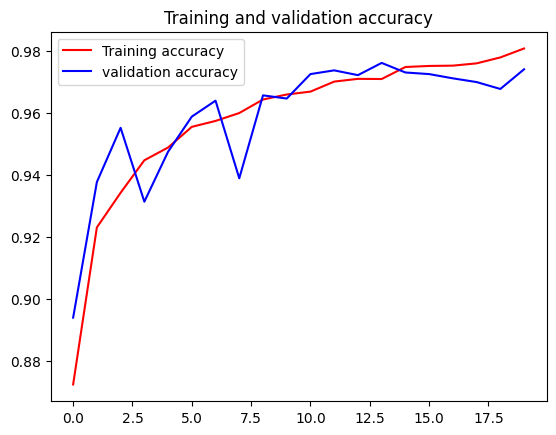

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='upper left')
plt.figure()

plt.show()

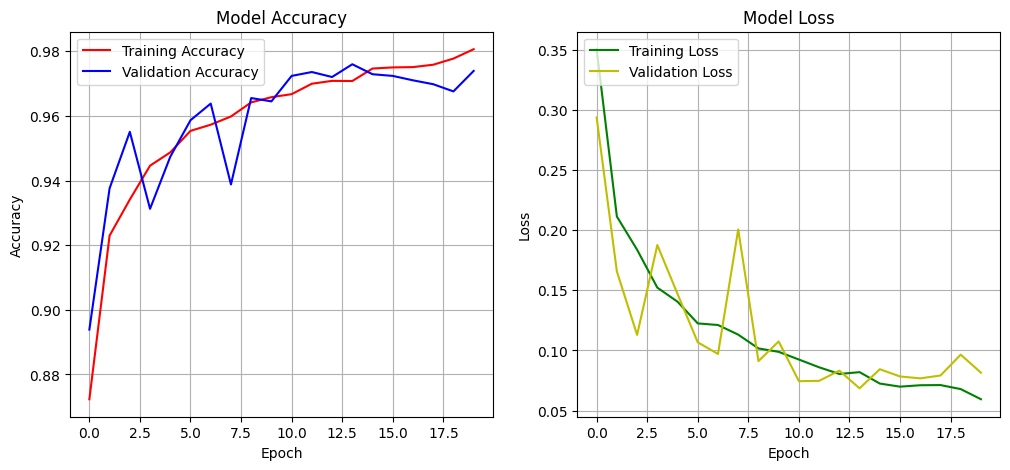

In [32]:
# Grafik plot value accuracy training sama validation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Grafik plot value loss training sama validation
plt.subplot(1, 2, 2)
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'y', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

In [33]:
from tensorflow import keras

# Load the trained model
model = keras.models.load_model("skripsi_efficientnetb3_002_augment_1.h5")



In [34]:
test_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT_TRAINDATA\test"

In [37]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (300, 300)
batch_size = 40

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # Change to 'categorical' if multi-class
    shuffle=False
)

# Get true labels
true_labels = test_generator.classes


Found 2922 images belonging to 4 classes.


In [38]:
pred_probs = model.predict(test_generator)

pred_labels = np.argmax(pred_probs, axis=1) 


74/74 [==============================] - 19s 262ms/step


In [39]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[861  12   0   9]
 [ 14 843   0   3]
 [  8   2 707   1]
 [ 18   3   1 440]]


In [40]:
from sklearn.metrics import classification_report, accuracy_score

# label class
class_labels = list(test_generator.class_indices.keys())

# classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_labels, digits=4))

# akurasi
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

   EarlyPreB     0.9556    0.9762    0.9658       882
        PreB     0.9802    0.9802    0.9802       860
        ProB     0.9986    0.9847    0.9916       718
      benign     0.9713    0.9524    0.9617       462

    accuracy                         0.9757      2922
   macro avg     0.9764    0.9734    0.9748      2922
weighted avg     0.9759    0.9757    0.9757      2922

Accuracy: 0.9757


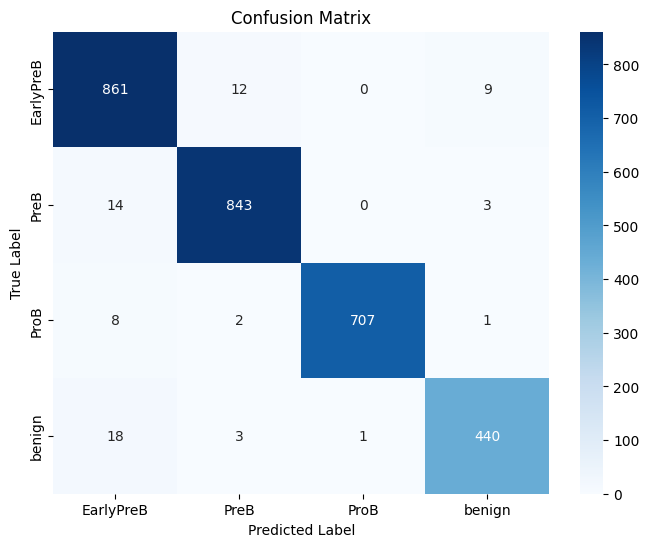

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
